In [30]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)
from functions.model3 import GAN
import datetime
import json
from qiskit.circuit import ParameterVector
from functions.data_preperation import process_model_data
from functions.q_generator import two_qubit_circuit_tickers
from functions.model_test import plot_training_metrics, get_latest_model_path

In [31]:
model_directory ="models/"
latest_model_path = get_latest_model_path(model_directory)
#latest_model_path="models/models_2809.1230"

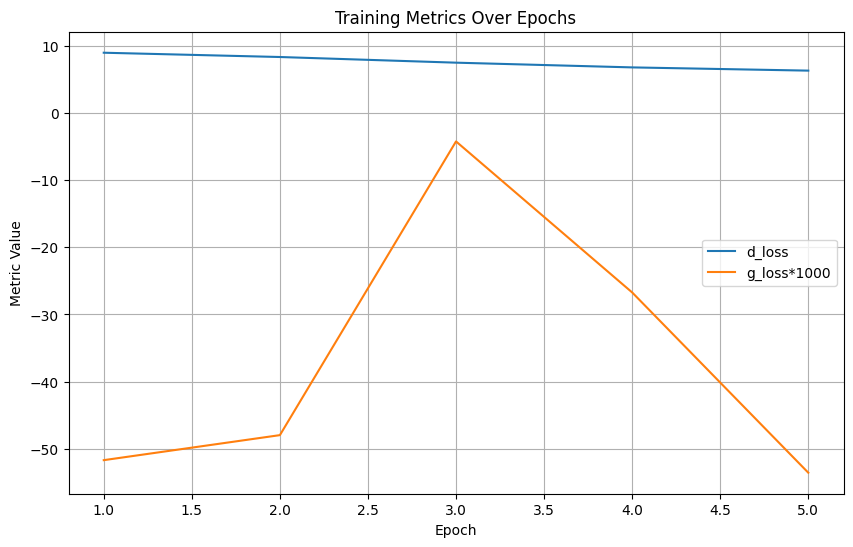

In [32]:
plot_training_metrics(f"{latest_model_path}/logs", generator_loss_scaling=1000)

In [33]:
targets = ["OC_next", "CO_next"]
features = ["Close", "High", "Low", "Open", "Volume", "MACD", "Signal_Line", "EMA_20"]
tickers = ['GOOG','AAPL','MSFT','AMZN']

In [34]:
feature_data, target_data = process_model_data(targets, features, tickers) #feature_data, target_data

/Users/a01milner/Documents/Schro-horse/functions/data_preperation.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/Users/a01milner/Documents/Schro-horse/functions/data_preperation.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/Users/a01milner/Documents/Schro-horse/functions/data_preperation.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/Users/a01milner/Documents/Schro-horse/functions/data_preperation.py:13: FutureWarning: YF.download() has changed argument auto_adjust default to True
  d

(1003, 32) (1003, 8)


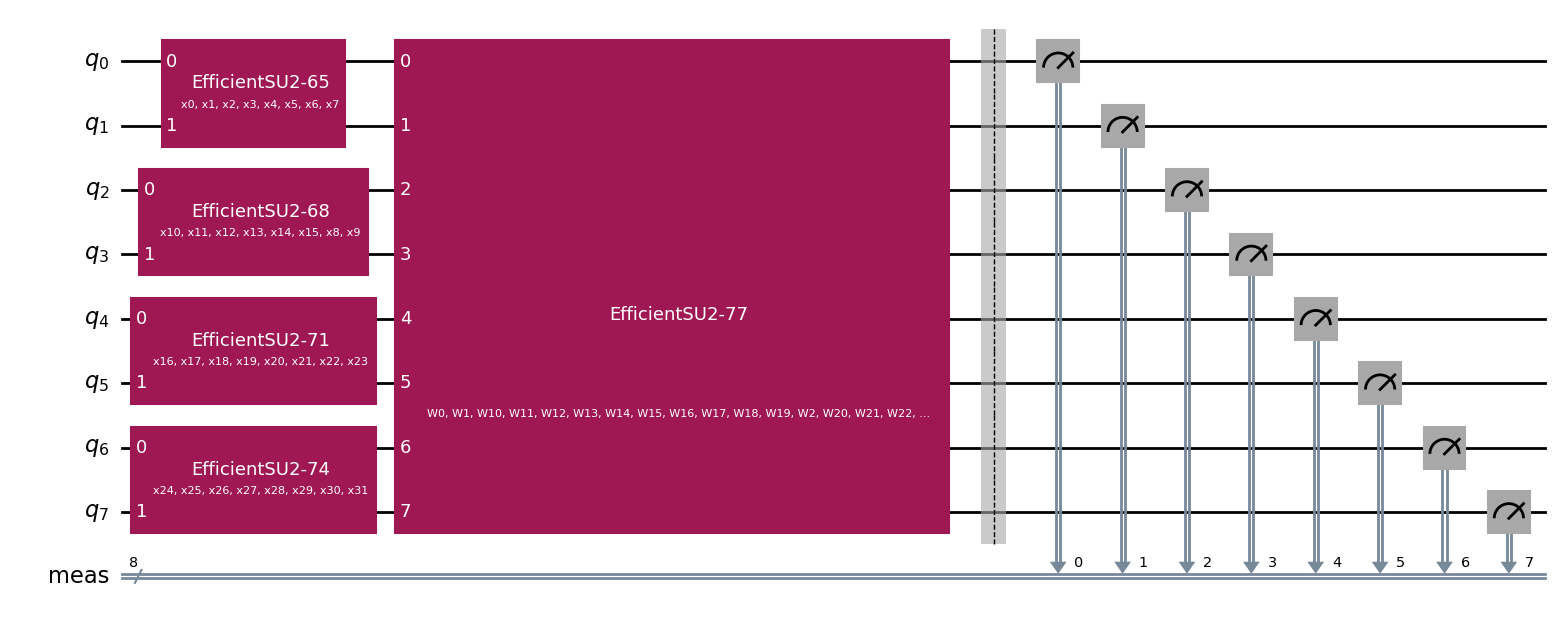

In [35]:
qc= two_qubit_circuit_tickers(tickers)
qc.draw('mpl')

In [36]:
def infer_parameter_groups(circuit):
        """
        Basic heuristic: names starting with x/data -> data params,
        names starting with w/theta/th -> trainable params.
        """
        data_prefixes = ("x", "data")
        weight_prefixes = ("w", "theta", "th")
        data_params, weight_params, other = [], [], []

        for p in circuit.parameters:
            name = p.name.lower()
            if name.startswith(data_prefixes):
                data_params.append(p)
            elif name.startswith(weight_prefixes):
                weight_params.append(p)
            else:
                other.append(p)

        # If ambiguous, put leftovers into weight_params by default
        weight_params += other
        return data_params, weight_params

## Loading weights into the model

In [37]:
#latest_model_path="models/models_2809.1018"
loaded_weights = np.load(f"{latest_model_path}/generator.npy")

In [38]:
data_params, weight_params = infer_parameter_groups(qc)


In [39]:
param_vector = qc.parameters
param_list = list(param_vector)

In [40]:
# mapping from Parameters to values
#weight_params=[param for param in param_list if param.name[:7]=="weights" ]
weight_param_dict = {param: val for param, val in zip(weight_params, loaded_weights)}

# Assign parameters to the circuit
qc_weighted = qc.assign_parameters(weight_param_dict)

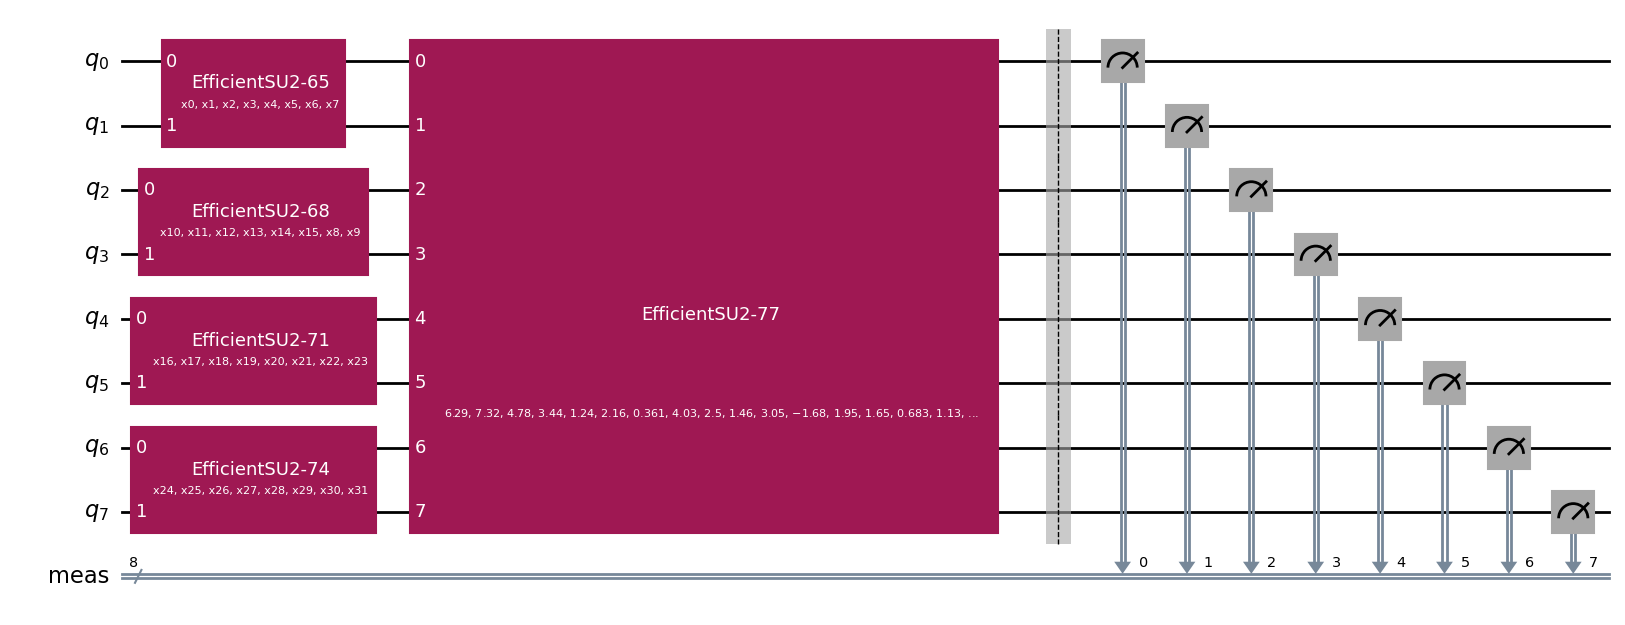

In [41]:
qc_weighted.draw('mpl')

### Encode data

In [42]:
#load in example data
input_data = feature_data[0]

#data_params = list(qc_weighted.parameters)
data_param_dict = {param: val for param, val in zip(data_params, input_data)}

print (data_param_dict)
# Assign data encodings to the circuit
qc_data = qc_weighted.assign_parameters(data_param_dict)


{Parameter(x0): -3.114508566595936, Parameter(x1): -3.128512281695925, Parameter(x10): -3.102226595158314, Parameter(x11): -3.127273951654059, Parameter(x12): -2.260857859364241, Parameter(x13): -1.0043936432030423, Parameter(x14): -1.1283162537636273, Parameter(x15): -3.140921191327359, Parameter(x16): -2.928103006437952, Parameter(x17): -2.9548338642296423, Parameter(x18): -2.890824378787691, Parameter(x19): -2.9216151109148876, Parameter(x2): -1.5221760809785019, Parameter(x20): 0.27385622905046647, Parameter(x21): 0.008237797823615445, Parameter(x22): -3.141592653589793, Parameter(x23): -3.054432811437849, Parameter(x24): -3.044504574858196, Parameter(x25): -3.014052339017291, Parameter(x26): -3.0434760271614265, Parameter(x27): -1.8544302521470988, Parameter(x28): -0.7192863290367648, Parameter(x29): -0.8785821901978301, Parameter(x3): -3.141592653589793, Parameter(x30): -0.18413510520773713, Parameter(x31): -0.14171180091247537, Parameter(x4): -0.12450018023531317, Parameter(x5):

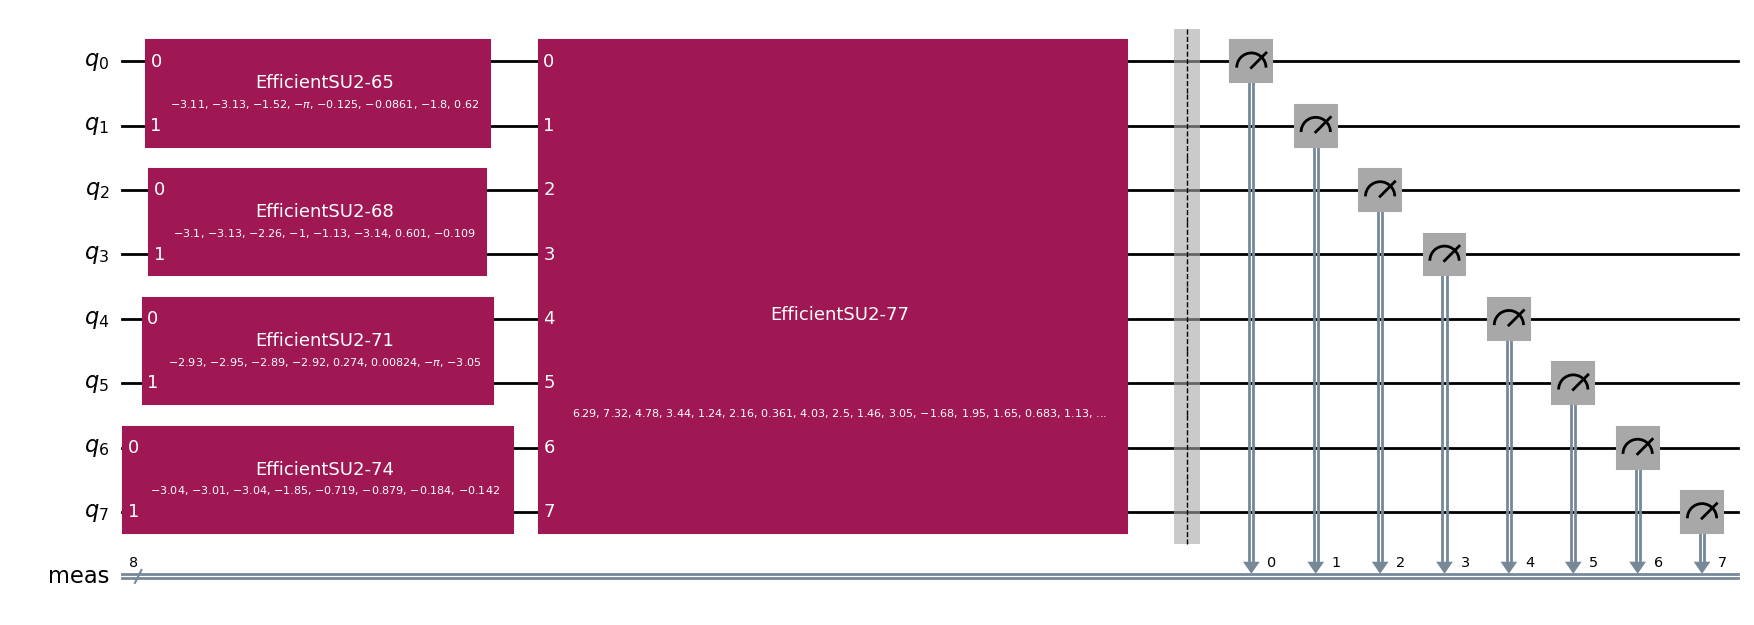

In [43]:
qc_data.draw('mpl')

### Run the circuit

In [44]:
from qiskit.quantum_info import SparsePauliOp
num_qubits = qc_data.num_qubits
observable = [SparsePauliOp.from_list([(f"{'I'*i}Z{'I'*(num_qubits-i-1)}", 1)]) for i in range(num_qubits)]

print(observable)

[SparsePauliOp(['ZIIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IZIIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIZIIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIZIIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIZIII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIZII'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIZI'],
              coeffs=[1.+0.j]), SparsePauliOp(['IIIIIIIZ'],
              coeffs=[1.+0.j])]


In [48]:
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit import transpile

service = QiskitRuntimeService()
#backend = service.least_busy()
backend = GenericBackendV2(num_qubits=num_qubits)
qc_transpiled = transpile(qc_data, backend=backend, optimization_level=3)

estimator = EstimatorV2(mode=backend)

pub = (qc_transpiled, observable) #primitive unified bloc program input for estimator
job = estimator.run([pub])
result = job.result()[0]
expectation_values = result.data.evs

management.get:WARNING:2025-09-28 20:42:59,101: Loading default saved account


In [49]:
expectation_values

array([ 0.28613281,  0.796875  ,  0.12109375, -0.06640625, -0.28076172,
        0.06103516, -0.48974609,  0.03027344])

In [50]:
target_data[0]

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([-0.13254137, -0.3487708 , -0.66223794,  0.6015468 , -0.54447484,
       -0.845509  , -0.3418808 , -0.0632446 ], dtype=float32)>